In [2]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open("SRInPressure.json") as datafile:
    data = json.load(datafile, encoding='utf-8')
dataset = pd.DataFrame(data)

dataset.set_index('dateTimeValues', inplace=True)
dataset['timeSeries'] = dataset['timeSeries'].apply(pd.to_numeric).astype(float)
dataset.drop(dataset.columns[[0,1]], inplace=True, axis=1)
#dataset.drop(dataset.columns[[1, 2]])


dataset.head()

,timeSeries
dateTimeValues,
2013-12-30 00:00:00,0.104970
2013-12-30 00:15:00,0.104360
2013-12-30 00:30:00,0.143093
2013-12-30 00:45:00,0.109712
2013-12-30 01:00:00,0.112431


In [62]:
'''tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')
tf.app.flags.DEFINE_string('work_dir', '', 'Working directory.')
FLAGS = tf.app.flags.FLAGS'''

In [4]:
dataset.index=pd.to_datetime(dataset.index)

dataset.head(10)

,timeSeries
dateTimeValues,
2013-12-30 00:00:00,0.104970
2013-12-30 00:15:00,0.104360
2013-12-30 00:30:00,0.143093
2013-12-30 00:45:00,0.109712
2013-12-30 01:00:00,0.112431
2013-12-30 01:15:00,0.131946
2013-12-30 01:30:00,0.110707
2013-12-30 01:45:00,0.133236
2013-12-30 02:00:00,0.126729


In [5]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [6]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,high=len(training_data)-steps)

    # Create Y data for time series in the batches
    data = np.array(train_set[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return data[:, :-1].reshape(-1, steps, 1), data[:, 1:].reshape(-1, steps, 1) 

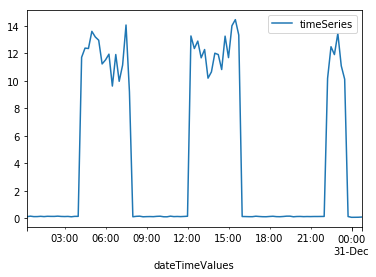

In [7]:
#train_set, test_set = split_train_test(dataset, 0.2)
#print(len(train_set), "train +", len(test_set), "test")



train_set = dataset[0:34944]
test_set= dataset[34945:35244]
train_set.head()
adg = train_set[1:100]

adg.plot()

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train_set.shape
train_scaled = train_set.values# scaler.fit_transform(train_set)
#test_scaled = scaler.transform(test_set)


In [202]:
'''tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')
tf.app.flags.DEFINE_string('work_dir', '', 'Working directory.')
FLAGS = tf.app.flags.FLAGS'''

In [21]:
import tensorflow as tf
tf.reset_default_graph()

In [22]:
# Just one feature, the time series
num_inputs = 1
num_time_steps = 672
num_neurons = 200#300 #200
num_outputs = 1
learning_rate = 0.0001#0.001 #0.0005
num_train_iterations = 50000#75000




# Size of the batch of data
batch_size = 1


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
#train_set=train_set.reshape(-1,num_time_steps,1)

# Also play around with GRUCell
#cell = tf.contrib.rnn.OutputProjectionWrapper(
   # tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    #output_size=num_outputs) 

# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.tanh),
    output_size=num_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32,parallel_iterations=64)
outputs.get_shape()
#states.get_shape()

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.9,centered=True,decay=0.9)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)



In [205]:
#train_set.plot()

In [23]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, "\tMSE:", mse)
    
    '''
    print('Done training!')
    # Export model
    export_path_base = FLAGS.work_dir
    export_path = os.path.join(
        tf.compat.as_bytes(export_path_base),
        tf.compat.as_bytes(str(FLAGS.model_version)))
    print('Exporting trained model to', export_path)
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(outputs)

    prediction_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'input': tensor_info_x},
          outputs={'output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
    builder.add_meta_graph_and_variables(
        sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={
          'prediction':
              prediction_signature,
      },
      legacy_init_op=legacy_init_op)

    builder.save()

    print('Done exporting!')'''

    # Save Model for Later
    #saver.save(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.save(sess, "/home/ml/sequence_modeling/GRUCell/GRUCell.ckpt")
   

0 	MSE: 42.3026
100 	MSE: 7.52956
200 	MSE: 4.15739
300 	MSE: 2.05436
400 	MSE: 1.69575
500 	MSE: 2.78069
600 	MSE: 1.37058
700 	MSE: 0.846975
800 	MSE: 1.50475
900 	MSE: 1.40923
1000 	MSE: 1.08652
1100 	MSE: 1.57482
1200 	MSE: 1.44315
1300 	MSE: 1.14019
1400 	MSE: 1.36928
1500 	MSE: 1.05832
1600 	MSE: 1.1936
1700 	MSE: 1.02019
1800 	MSE: 0.992009
1900 	MSE: 0.869821
2000 	MSE: 0.865051
2100 	MSE: 1.18385
2200 	MSE: 0.941239
2300 	MSE: 0.895702
2400 	MSE: 1.2274
2500 	MSE: 0.978048
2600 	MSE: 1.01909
2700 	MSE: 0.962868
2800 	MSE: 0.848741
2900 	MSE: 0.767346
3000 	MSE: 0.946861
3100 	MSE: 1.00687
3200 	MSE: 1.0134
3300 	MSE: 1.20353
3400 	MSE: 1.69663
3500 	MSE: 1.01498
3600 	MSE: 1.01947
3700 	MSE: 1.03553
3800 	MSE: 0.897314
3900 	MSE: 0.992092
4000 	MSE: 0.815231
4100 	MSE: 1.10806
4200 	MSE: 1.00226
4300 	MSE: 0.966414
4400 	MSE: 0.947004
4500 	MSE: 1.20414
4600 	MSE: 0.976924
4700 	MSE: 1.16148
4800 	MSE: 0.89315
4900 	MSE: 1.04769
5000 	MSE: 0.897679
5100 	MSE: 1.079
5200 	MSE: 

40200 	MSE: 0.700441
40300 	MSE: 0.567087
40400 	MSE: 0.548818
40500 	MSE: 0.815167
40600 	MSE: 0.643538
40700 	MSE: 0.484712
40800 	MSE: 0.500554
40900 	MSE: 0.668183
41000 	MSE: 0.514641
41100 	MSE: 0.691855
41200 	MSE: 0.589625
41300 	MSE: 0.580577
41400 	MSE: 0.599522
41500 	MSE: 0.628513
41600 	MSE: 0.603668
41700 	MSE: 0.469248
41800 	MSE: 0.48677
41900 	MSE: 0.490304
42000 	MSE: 0.440651
42100 	MSE: 0.893994
42200 	MSE: 0.764597
42300 	MSE: 0.570767
42400 	MSE: 0.48306
42500 	MSE: 0.486559
42600 	MSE: 0.531194
42700 	MSE: 0.49394
42800 	MSE: 0.58884
42900 	MSE: 0.502163
43000 	MSE: 0.876987
43100 	MSE: 0.491244
43200 	MSE: 0.685343
43300 	MSE: 0.475875
43400 	MSE: 0.523134
43500 	MSE: 0.43264
43600 	MSE: 0.509852
43700 	MSE: 0.573985
43800 	MSE: 0.493028
43900 	MSE: 0.500766
44000 	MSE: 0.537917
44100 	MSE: 0.528244
44200 	MSE: 0.517492
44300 	MSE: 0.551699
44400 	MSE: 0.444219
44500 	MSE: 0.426016
44600 	MSE: 0.423848
44700 	MSE: 0.470287
44800 	MSE: 0.522097
44900 	MSE: 0.3642

In [24]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    #saver.restore(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.restore(sess, "/home/ml/sequence_modeling/GRUCell/GRUCell.ckpt")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-num_time_steps:])
    
    ## Now create a for loop that 
    for iteration in range(100):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(-1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from /home/ml/sequence_modeling/GRUCell/GRUCell.ckpt


In [25]:
len(train_seed[num_time_steps:])

100

In [26]:
results = np.array(train_seed[num_time_steps:]).reshape(100,1)
#results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(100,1))

In [27]:
new_test_set = test_set.head(100)


In [28]:
new_test_set['predicted'] = results

/home/ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
#print(new_test_set)

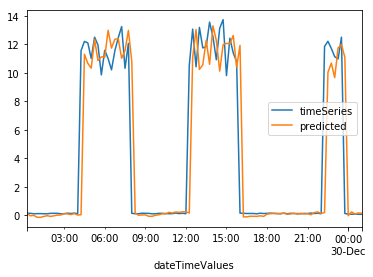

In [29]:
new_test_set.plot()